# Approach : Context-Aware Approximate Scientific Computing

## Description / Goal

Goal: Tailoring simulation model to a context of usage through an execution budget, by automatically and systematically applying approximate computing thanks to predictive models.

# Pipeline

## Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pandas as pd
import random
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import metrics
random.seed(42)

## Functions to load 

In [3]:
def pipeline_time_prediction(budget, ratio_train):
    # Retrieve data
    df_data = pd.read_csv(os.path.join(path, "data/", "Input_Data_Time_ValidMetric_Features_Rates_" + str(nb_rates) + "_Features_" + "Geomorph_CVHV_Saturation_Cells" + "_" + str(scale) + "_Comparable.csv"), sep=";")
    sites_completes = df_data.SiteNumber.unique()
    # Split geographical sites into training and testing cases
    training_cases, testing_cases = split_training_testing_cases(sites_completes, ratio_train)
    # Extracting training and testing datasets
    X_test, y_test_pred, y_test, data_test = get_time_prediction(df_data, training_cases, testing_cases)
    
    true_positive_time, true_negative_time, false_positive_time, false_negative_time, idxs = get_evaluation_from_time_prediction(y_test_pred, y_test, X_test, data_test)


    return df_data, training_cases, testing_cases, idxs, true_positive_time, true_negative_time, false_positive_time, false_negative_time

In [4]:
def split_training_testing_cases(sites_completes, ratio_train):
    #Computing the number of sites that are used for the training
    training_nb_cases = round(len(sites_completes) * ratio_train)

    # Selecting the sites for the training and testing sets randomly 
    training_cases = random.sample(sites_completes.tolist(), training_nb_cases)
    testing_cases = [x for x in sites_completes.tolist() if x not in training_cases]
    
    return training_cases, testing_cases

In [5]:
def get_time_prediction(df_data, training_cases, testing_cases):
    data_train, data_test = retrieve_list_cases_and_split_data_BVE(df_data, training_cases, testing_cases)
    X_train, y_train, X_test, y_test = extract_features_and_outputs_datasets_BVE(data_train, data_test, features)
    forest = train_forest(X_train, y_train)
    y_test_pred = forest.predict(X_test)
    #mse, r2, rmse = compute_standard_metrics(y_test, y_test_pred)
    #print("MSE: ", mse)
    #print("RMSE: ", rmse)
    #print("R2: ", r2)
    data_test = update_and_store_data_with_time_pred(path, data_test, y_test, y_test_pred, testing_cases)
    return X_test, y_test_pred, y_test, data_test
    

In [6]:
def retrieve_list_cases_and_split_data_BVE(df_data, training_cases, testing_cases):
    
    # Retrieving the dataset for the training phase
    data_train = extract_data_from_list_of_sites(df_data, training_cases)
    
    # Retrieving the dataset for the testing phase
    data_test = extract_data_from_list_of_sites(df_data, testing_cases)

    return data_train, data_test

In [7]:
def extract_data_from_list_of_sites(data_complete, cases):
    data_cases = pd.DataFrame(columns=data_complete.columns)
    for case in cases:
        data_case = data_complete.loc[(data_complete['SiteNumber'] == case)]
        data_cases = pd.concat([data_cases, data_case], sort=False)
        
    return data_cases

In [8]:
def extract_features_and_outputs_datasets_BVE(data_train, data_test, features):
    # load names of all the features contained in the dataset to extract the data we want from
    global all_features
    
    y_train = data_train.filter(["SiteNumber", "Time"], axis=1)
    X_train = data_train.drop(["Chronicle", "Validation Metric", "Accuracy", "Time"], axis=1)
    del y_train["SiteNumber"]
    del X_train["SiteNumber"]
    
    y_test = data_test.filter(["SiteNumber", "Time"], axis=1)
    X_test = data_test.drop(["Chronicle", "Validation Metric", "Accuracy", "Time"], axis=1)
    del y_test["SiteNumber"]
    del X_test["SiteNumber"]
    
    
    features_to_remove = [feature for feature in all_features if feature not in features]
    for feature in features_to_remove:
        del X_train[str(feature)]
        del X_test[str(feature)]

    return X_train, y_train, X_test, y_test 

In [9]:
def train_forest(X_train, y_train):
    forest = RandomForestRegressor(
        n_estimators=1000, criterion='squared_error', random_state=1, n_jobs=-1, oob_score = True, bootstrap = True
    )
    forest.fit(X_train, y_train.values.ravel())

    return forest

In [10]:
def compute_standard_metrics(y_test, y_test_pred):

    mse = mean_squared_error(y_test.values.ravel(), y_test_pred)
    r2 = r2_score(y_test.values.ravel(), y_test_pred)
    rmse = metrics.mean_squared_error(y_test.values.ravel(), y_test_pred, squared=False)

    return mse, r2, rmse

In [11]:
def update_and_store_data_with_time_pred(path, data_test, y_test, y_test_pred, testing_cases):
    suffixe = "_".join(map(str,list(map(int, sorted(testing_cases)))))
    # If we want the testing dataset to correspond to one unique site instead of a ratio (e.g., 20%)
    data_test = data_test.assign(Timetest=y_test.values.ravel())
    data_test = data_test.assign(TimePred=y_test_pred)
    
    data_test.to_csv(os.path.join(path,"data/Output_Data/Data_Test_With_Time_pred_Rates_" + str(nb_rates) + "_Features_" + str('_'.join(features)) + "_" + str(scale)  + "_" + str(suffixe) + ".csv"), index=False, sep=";")
    return data_test

In [12]:
def get_evaluation_from_time_prediction(y_test_pred, y_test, X_test, data_test):
    chuncks_pred = list()
    true_positive_time = 0
    true_negative_time = 0
    false_positive_time = 0
    false_negative_time = 0

    for i in range(0, len(y_test_pred), 30):
        chuncks_pred.append(y_test_pred[i:i+30])
    idxs = list()
    site = 0
    for site_data in chuncks_pred:
        first_time_under_budget = 0
        item_site = 0
        site += 1
        for pred_time in site_data:
            item_site +=1
            if pred_time < budget:
                first_time_under_budget +=1
                if first_time_under_budget == 2:
                    index_for_site = item_site-1
                    
                    idxs.append(((site-1)*30)+ index_for_site)
                    pred_time_approach = round(pred_time)

                    pred_rate = int(X_test.iloc[[((site-1)*30)+ index_for_site]]["Rate"])
                    real_time_approach = int(y_test.iloc[[((site-1)*30)+ index_for_site]]["Time"])
                    
                    # In reality, is the simulation of this approximation rate respecting the budget
                    prediction_time_evaluation = get_evaluation_with_time_prediction_under_budget(budget, real_time_approach)
                    
                    if prediction_time_evaluation:
                        true_positive_time += 1
                        print("TP p")
                    else:
                        false_positive_time += 1
                        print("FP p")
                    break
                    
        if item_site == 30 :
            idxs.append(-9)
            index_debut = (site - 1) * 30
            for i in range(index_debut, index_debut + 30):
                real_time_approach = int(data_test.iloc[[i]]["Time"])
                if real_time_approach < budget:
                    false_negative_time += 1
                    print("FN p")
                    break
                if i == index_debut + 30 - 1:
                    true_negative_time += 1
                    print("TN p")

            
    
    return true_positive_time, true_negative_time, false_positive_time, false_negative_time, idxs

In [13]:
def get_evaluation_with_time_prediction_under_budget(budget, real_time_approach):
    # In reality, is the simulation of this approximation rate respecting the budget
    if real_time_approach < budget:
        prediction_time_evaluation = 1
    else:
        prediction_time_evaluation = 0
        
    return prediction_time_evaluation

## Pipeline for validity 

In [14]:
 def pipeline_prediction_validation(df_data, training_cases, testing_cases, idxs, features_validity):   
    y_test_pred_valid, y_test_valid = get_validity_prediction(df_data, training_cases, testing_cases, features_validity)
    predicted_and_real_validity_values = get_validity_prediction_values_for_corresponding_approximation_rates(y_test_pred_valid, y_test_valid, idxs)
    true_positive_valid = 0
    true_negative_valid = 0
    false_positive_valid = 0
    false_negative_valid = 0

    for predicted_validity in predicted_and_real_validity_values:
        predicted_validity_value = predicted_validity[0]
        real_validity_value = predicted_validity[1]
        if predicted_validity_value == real_validity_value:
            if predicted_validity_value:
                true_positive_valid +=1
                print("TP validity")
            else:
                true_negative_valid += 1
                print("TN validity")
        else:
            if predicted_validity_value:
                false_positive_valid +=1
                print("FP validity ")
            else:
                false_negative_valid += 1
                print("FN validity")

    return true_positive_valid, true_negative_valid, false_positive_valid, false_negative_valid

In [15]:
def get_validity_prediction(df_data, training_cases, testing_cases, features_validity):
    global k
    df_data["Validity"] = np.where(df_data["Validation Metric"] > validity_threshold, 0, 1)
    data_train_validity, data_test_validity = retrieve_list_cases_and_split_data_BVE(df_data, training_cases, testing_cases)
    X_train_validity, y_train_validity, X_test_validity, y_test_validity = extract_features_and_outputs_datasets_BVE_validity(data_train_validity, data_test_validity, features_validity)
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train_validity, y_train_validity.values.ravel().astype(int))
    y_test_pred_validity = classifier.predict(X_test_validity)
    #acc_score = compute_score(y_test_validity, y_test_pred_validity)
    #print("Validity Accuracy Score:", acc_score)
    
    return y_test_pred_validity, y_test_validity

In [16]:
def extract_features_and_outputs_datasets_BVE_validity(data_train, data_test, features):
    # load names of all the features contained in the dataset to extract the data we want from
    global all_features
    
    X_train, y_train = create_input_and_output_datasets_for_validity(data_train)
    X_test, y_test = create_input_and_output_datasets_for_validity(data_test)
    
    
    features_to_remove = [feature for feature in all_features if feature not in features]
    for feature in features_to_remove:
        del X_train[str(feature)]
        del X_test[str(feature)]

    return X_train, y_train, X_test, y_test 

In [17]:
def create_input_and_output_datasets_for_validity(data):
    y_data = data.filter(["SiteNumber", "Validity"], axis=1)
    X_data = data.drop(["Chronicle", "Validation Metric", "Accuracy", "Time", "Validity"], axis=1)
    del y_data["SiteNumber"]
    del X_data["SiteNumber"]
    return X_data, y_data

In [18]:
def compute_score(y_test, y_test_pred):
    acc_score = metrics.accuracy_score(y_test.values.ravel().astype(int), y_test_pred)
    return acc_score

In [19]:
def get_validity_prediction_values_for_corresponding_approximation_rates(y_test_pred_valid, y_test_real_valid, idxs):
    chuncks_pred_valid = list()
    predicted_and_real_validity_values = list()

    for i in range(0, len(y_test_pred_valid), 30):
        chuncks_pred_valid.append(y_test_pred_valid[i:i+30])

    site = 0
    for value_sites in chuncks_pred_valid:
        # Checking if the prediction for the approximation rate led to no simulation under the execution budget
        if idxs[site] == -9: 
            predicted_and_real_validity_values.append([1, 1])
        else:
            valid_pred = y_test_pred_valid[idxs[site]]
            valid_real = int(y_test_real_valid.iloc[[idxs[site]]]["Validity"])
        
            predicted_and_real_validity_values.append([valid_pred, valid_real])
        site+=1
    
    return predicted_and_real_validity_values

## Parameters

In [20]:
path = os.path.abspath(os.path.join(os.path.abspath(""), os.pardir))
nb_rates = 30
chronicle = 0
scale = "BVE"

# Different sets of features 
set_geomorph = ["Slope", "Elevation", "LC", "CW", "Area"]
set_CVHV = ["Coastal Vulnerability", "Hydrological Vulnerability"]
set_saturation= ["Satured Zone Area", "Vulnerability Sum", "Vulnerability Rate"]
set_cells = ["Number of Cells"]
all_features = set_geomorph + set_CVHV + set_saturation + set_cells

# We select the type of features we want to use for training our model
features = set_cells

## Replications x 25

In [21]:
validity_threshold = 0.1
k=3
features_valid = set_geomorph
budgets = [120, 300, 600, 900, 1800, 3600, 7200, 12600, 18000]
ratio_train = 0.95

true_positive_times = {}
true_negative_times = {}
false_positive_times = {}
false_negative_times = {}
true_positive_valids = {}
true_negative_valids = {}
false_positive_valids = {}
false_negative_valids = {}
true_positive_approach = {}
true_negative_approach = {}
false_positive_approach = {}
false_negative_approach = {}

for budget in budgets:
    true_positive_times[budget] = 0
    true_negative_times[budget] = 0
    false_positive_times[budget] = 0
    false_negative_times[budget] = 0
    true_positive_valids[budget] = 0
    true_negative_valids[budget] = 0
    false_positive_valids[budget] = 0
    false_negative_valids[budget] = 0
    true_positive_approach[budget] = 0
    true_negative_approach[budget] = 0
    false_positive_approach[budget] = 0
    false_negative_approach[budget] = 0


for i in range(25):
    print("------------")
    print("Replication", i+1)
    correct_approach_replication = 0
    for budget in budgets:
        print('----')
        print("Budget:", budget)
        df_data, training_cases, testing_cases, idxs, true_positive_time, true_negative_time, false_positive_time, false_negative_time = pipeline_time_prediction(budget, ratio_train)
        true_positive_valid, true_negative_valid, false_positive_valid, false_negative_valid = pipeline_prediction_validation(df_data, training_cases, testing_cases, idxs,features_valid)
                

        true_positive_times[budget] += true_positive_time
        true_negative_times[budget] += true_negative_time
        false_positive_times[budget] += false_positive_time
        false_negative_times[budget] += false_negative_time
        true_positive_valids[budget] += true_positive_valid
        true_negative_valids[budget] += true_negative_valid
        false_positive_valids[budget] += false_positive_valid
        false_negative_valids[budget] += false_negative_valid

        if true_positive_time and true_positive_valid:
            true_positive_approach[budget] += 1
        elif (false_positive_time and true_positive_valid) or (false_positive_time and false_positive_valid) or (true_positive_time and false_positive_valid):
            false_positive_approach[budget] += 1
        elif (true_positive_time and false_negative_valid) or (false_negative_time and true_positive_valid) or (false_negative_time and false_negative_valid):
            false_negative_approach[budget] += 1
        else:
            true_negative_approach[budget] += 1

print("------------")

------------
Replication 1
----
Budget: 120
FP p
TN validity
----
Budget: 300
FP p
TP validity
----
Budget: 600
TP p
TN validity
----
Budget: 900
TP p
TN validity
----
Budget: 1800
TP p
TN validity
----
Budget: 3600
TP p
FN validity
----
Budget: 7200
TP p
TP validity
----
Budget: 12600
TP p
TP validity
----
Budget: 18000
TP p
TP validity
------------
Replication 2
----
Budget: 120
FP p
TN validity
----
Budget: 300
TP p
TN validity
----
Budget: 600
TP p
FP validity 
----
Budget: 900
TP p
TN validity
----
Budget: 1800
TP p
TN validity
----
Budget: 3600
TP p
TP validity
----
Budget: 7200
TP p
TP validity
----
Budget: 12600
TP p
TP validity
----
Budget: 18000
TP p
TP validity
------------
Replication 3
----
Budget: 120
TP p
TN validity
----
Budget: 300
FN p
TP validity
----
Budget: 600
TP p
TN validity
----
Budget: 900
TP p
FP validity 
----
Budget: 1800
TP p
TN validity
----
Budget: 3600
TP p
FN validity
----
Budget: 7200
TP p
TP validity
----
Budget: 12600
TP p
TP validity
----
Budget: 1

# Accuracy scores

## Approximation rate

In [22]:
Accuracy_times = {}

for budget in budgets:

    true_prediction_times = true_positive_times[budget] + true_negative_times[budget]
    number_of_prediction_times = true_prediction_times + false_positive_times[budget] + false_negative_times[budget]

    Accuracy_times[budget] = float(true_prediction_times) / float(number_of_prediction_times)
    print(Accuracy_times[budget])

0.72
0.72
0.8
0.84
0.88
0.68
0.92
1.0
1.0


In [51]:
precision_times = {}

for budget in budgets:
    print("budget:", budget)
    number_positive_pred_times = true_positive_times[budget] + false_positive_times[budget]
    if number_positive_pred_times == 0:
        precision_t = 0
    else:
        precision_t = float(true_positive_times[budget]) / float(number_positive_pred_times)
    precision_times[budget] = precision_t
    print(precision_times[budget])

budget: 120
0.5
budget: 300
0.8571428571428571
budget: 600
0.8
budget: 900
0.84
budget: 1800
0.88
budget: 3600
0.68
budget: 7200
0.92
budget: 12600
1.0
budget: 18000
1.0


In [53]:
recall_times = {}

for budget in budgets:
    print("budget:", budget)
    number_positive_real_times = true_positive_times[budget] + false_negative_times[budget]
    if number_positive_real_times == 0:
        recall_t = 0
    else:
        recall_t = float(true_positive_times[budget]) / float(number_positive_real_times)
    recall_times[budget] = recall_t
    print(recall_times[budget])

budget: 120
1.0
budget: 300
0.8181818181818182
budget: 600
1.0
budget: 900
1.0
budget: 1800
1.0
budget: 3600
1.0
budget: 7200
1.0
budget: 12600
1.0
budget: 18000
1.0


In [54]:
f_score_times = {}

for budget in budgets:
    if (precision_times[budget] + recall_times[budget]) == 0:
        f_score_times[budget] = 0
    else:
        f_score_times[budget] = (2 * precision_times[budget] * recall_times[budget]) / (precision_times[budget] + recall_times[budget])
    print(f_score_times[budget])

0.6666666666666666
0.8372093023255814
0.888888888888889
0.9130434782608696
0.9361702127659575
0.8095238095238095
0.9583333333333334
1.0
1.0


In [55]:
import statistics
print("median accuracy:", statistics.median(Accuracy_times.values()))
print("median precision:", statistics.median(precision_times.values()))
print("median recall:", statistics.median(recall_times.values()))
print("median F-score:", statistics.median(f_score_times.values()))

median accuracy: 0.84
median precision: 0.8571428571428571
median recall: 1.0
median F-score: 0.9130434782608696


In [56]:
print("stdev accuracy:", statistics.stdev(Accuracy_times.values()))
print("stdev precision:", statistics.stdev(precision_times.values()))
print("stdev recall:", statistics.stdev(recall_times.values()))
print("stdev F-score:", statistics.stdev(f_score_times.values()))

stdev accuracy: 0.12000000000000001
stdev precision: 0.15871793603734471
stdev recall: 0.060606060606060594
stdev F-score: 0.10646268079834356


In [57]:
print("mean accuracy:", statistics.mean(Accuracy_times.values()))
print("mean precision:", statistics.mean(precision_times.values()))
print("mean recall:", statistics.mean(recall_times.values()))
print("mean F-score:", statistics.mean(f_score_times.values()))

mean accuracy: 0.84
mean precision: 0.8307936507936508
mean recall: 0.9797979797979798
mean F-score: 0.8899817435294564


In [58]:
print("min accuracy:", min(Accuracy_times.values()))
print("min precision:", min(precision_times.values()))
print("min recall:", min(recall_times.values()))
print("min F-score:", min(f_score_times.values()))

min accuracy: 0.68
min precision: 0.5
min recall: 0.8181818181818182
min F-score: 0.6666666666666666


In [59]:
print("max accuracy:", max(Accuracy_times.values()))
print("max precision:", max(precision_times.values()))
print("max recall:", max(recall_times.values()))
print("max F-score:", max(f_score_times.values()))

max accuracy: 1.0
max precision: 1.0
max recall: 1.0
max F-score: 1.0


## Validity

In [23]:
Accuracy_valids = {}


for budget in budgets:

    true_prediction_valids = true_positive_valids[budget] + true_negative_valids[budget]
    number_of_prediction_valids = true_prediction_valids + false_positive_valids[budget] + false_negative_valids[budget]

    Accuracy_valids[budget] = float(true_prediction_valids) / float(number_of_prediction_valids)
    print(Accuracy_valids[budget])

1.0
0.96
0.92
0.88
0.88
0.64
1.0
1.0
1.0


In [43]:
precision_valids = {}

for budget in budgets:
    print("budget:", budget)
    number_positive_pred_valids = true_positive_valids[budget] + false_positive_valids[budget]
    if number_positive_pred_valids == 0:
        precis_valids = 0
    else:
        precis_valids = float(true_positive_valids[budget]) / float(number_positive_pred_valids)
    precision_valids[budget] = precis_valids
    print(precision_valids[budget])

budget: 120
1.0
budget: 300
1.0
budget: 600
0.7142857142857143
budget: 900
0.7
budget: 1800
0.9090909090909091
budget: 3600
0.8333333333333334
budget: 7200
1.0
budget: 12600
1.0
budget: 18000
1.0


In [44]:
recall_valids = {}

for budget in budgets:
    print("budget:", budget)
    number_positive_real_valids = true_positive_valids[budget] + false_negative_valids[budget]
    if number_positive_real_valids == 0:
        recall_v = 0
    else:
        recall_v = float(true_positive_valids[budget]) / float(number_positive_real_valids)
    recall_valids[budget] = recall_v
    print(recall_valids[budget])

budget: 120
1.0
budget: 300
0.8571428571428571
budget: 600
1.0
budget: 900
1.0
budget: 1800
0.8333333333333334
budget: 3600
0.7142857142857143
budget: 7200
1.0
budget: 12600
1.0
budget: 18000
1.0


In [45]:
f_score_valids = {}

for budget in budgets:
    if (precision_valids[budget] + recall_valids[budget]) == 0:
        f_score_valids[budget] = 0
    else:
        f_score_valids[budget] = (2 * precision_valids[budget] * recall_valids[budget]) / (precision_valids[budget] + recall_valids[budget])
    print(f_score_valids[budget])

1.0
0.923076923076923
0.8333333333333333
0.8235294117647058
0.8695652173913043
0.7692307692307692
1.0
1.0
1.0


In [46]:
import statistics
print("median accuracy:", statistics.median(Accuracy_valids.values()))
print("median precision:", statistics.median(precision_valids.values()))
print("median recall:", statistics.median(recall_valids.values()))
print("median F-score:", statistics.median(f_score_valids.values()))

median accuracy: 0.96
median precision: 1.0
median recall: 1.0
median F-score: 0.923076923076923


In [47]:
print("stdev accuracy:", statistics.stdev(Accuracy_valids.values()))
print("stdev precision:", statistics.stdev(precision_valids.values()))
print("stdev recall:", statistics.stdev(recall_valids.values()))
print("stdev F-score:", statistics.stdev(f_score_valids.values()))

stdev accuracy: 0.116619037896906
stdev precision: 0.12681657498398544
stdev recall: 0.10633143656328779
stdev F-score: 0.0917095589687451


In [48]:
print("mean accuracy:", statistics.mean(Accuracy_valids.values()))
print("mean precision:", statistics.mean(precision_valids.values()))
print("mean recall:", statistics.mean(recall_valids.values()))
print("mean F-score:", statistics.mean(f_score_valids.values()))

mean accuracy: 0.92
mean precision: 0.9063011063011063
mean recall: 0.9338624338624338
mean F-score: 0.9131928505330039


In [49]:
print("min accuracy:", min(Accuracy_valids.values()))
print("min precision:", min(precision_valids.values()))
print("min recall:", min(recall_valids.values()))
print("min F-score:", min(f_score_valids.values()))

min accuracy: 0.64
min precision: 0.7
min recall: 0.7142857142857143
min F-score: 0.7692307692307692


In [50]:
print("max accuracy:", max(Accuracy_valids.values()))
print("max precision:", max(precision_valids.values()))
print("max recall:", max(recall_valids.values()))
print("max F-score:", max(f_score_valids.values()))

max accuracy: 1.0
max precision: 1.0
max recall: 1.0
max F-score: 1.0


## Approach

In [24]:
Accuracy_approach = {}

for budget in budgets:

    true_prediction_approach = true_positive_approach[budget] + true_negative_approach[budget]
    number_of_prediction_approach = true_prediction_approach + false_positive_approach[budget] + false_negative_approach[budget]

    Accuracy_approach[budget] = float(true_prediction_approach) / float(number_of_prediction_approach)
    print(Accuracy_approach[budget])

1.0
0.8
0.8
0.8
0.84
0.52
0.92
1.0
1.0


In [25]:
# Appropriate when minimizing false positives is the focus

precision_approach = {}

for budget in budgets:
    print("budget:", budget)
    number_positive_pred = true_positive_approach[budget] + false_positive_approach[budget]
    if number_positive_pred == 0:
        precision = 0
    else:
        precision = float(true_positive_approach[budget]) / float(number_positive_pred)
    precision_approach[budget] = precision
    print(precision_approach[budget])
    

budget: 120
1.0
budget: 300
0.5
budget: 600
0.2857142857142857
budget: 900
0.5
budget: 1800
0.8181818181818182
budget: 3600
0.6111111111111112
budget: 7200
0.92
budget: 12600
1.0
budget: 18000
1.0


In [26]:
#Appropriate when minimizing false negatives is the focus.

recall_approach = {}

for budget in budgets:
    print("budget:", budget)
    number_positive_real = true_positive_approach[budget] + false_negative_approach[budget]
    if number_positive_real == 0:
        recall = 0
    else:
        recall = float(true_positive_approach[budget]) / float(number_positive_real)
    recall_approach[budget] = recall
    print(recall_approach[budget])

budget: 120
1.0
budget: 300
0.2
budget: 600
1.0
budget: 900
1.0
budget: 1800
0.8181818181818182
budget: 3600
0.6875
budget: 7200
1.0
budget: 12600
1.0
budget: 18000
1.0


In [27]:
f_score = {}

for budget in budgets:
    if (precision_approach[budget] + recall_approach[budget]) == 0:
        f_score[budget] = 0
    else:
        f_score[budget] = (2 * precision_approach[budget] * recall_approach[budget]) / (precision_approach[budget] + recall_approach[budget])
    print(f_score[budget])

1.0
0.28571428571428575
0.4444444444444445
0.6666666666666666
0.8181818181818182
0.6470588235294118
0.9583333333333334
1.0
1.0


[1.0, 0.8, 0.8, 0.8, 0.84, 0.52, 0.92, 1.0, 1.0]
[1.0, 0.5, 0.2857142857142857, 0.5, 0.8181818181818182, 0.6111111111111112, 0.92, 1.0, 1.0]
[1.0, 0.2, 1.0, 1.0, 0.8181818181818182, 0.6875, 1.0, 1.0, 1.0]
[120, 300, 600, 900, 1800, 3600, 7200, 12600, 18000]


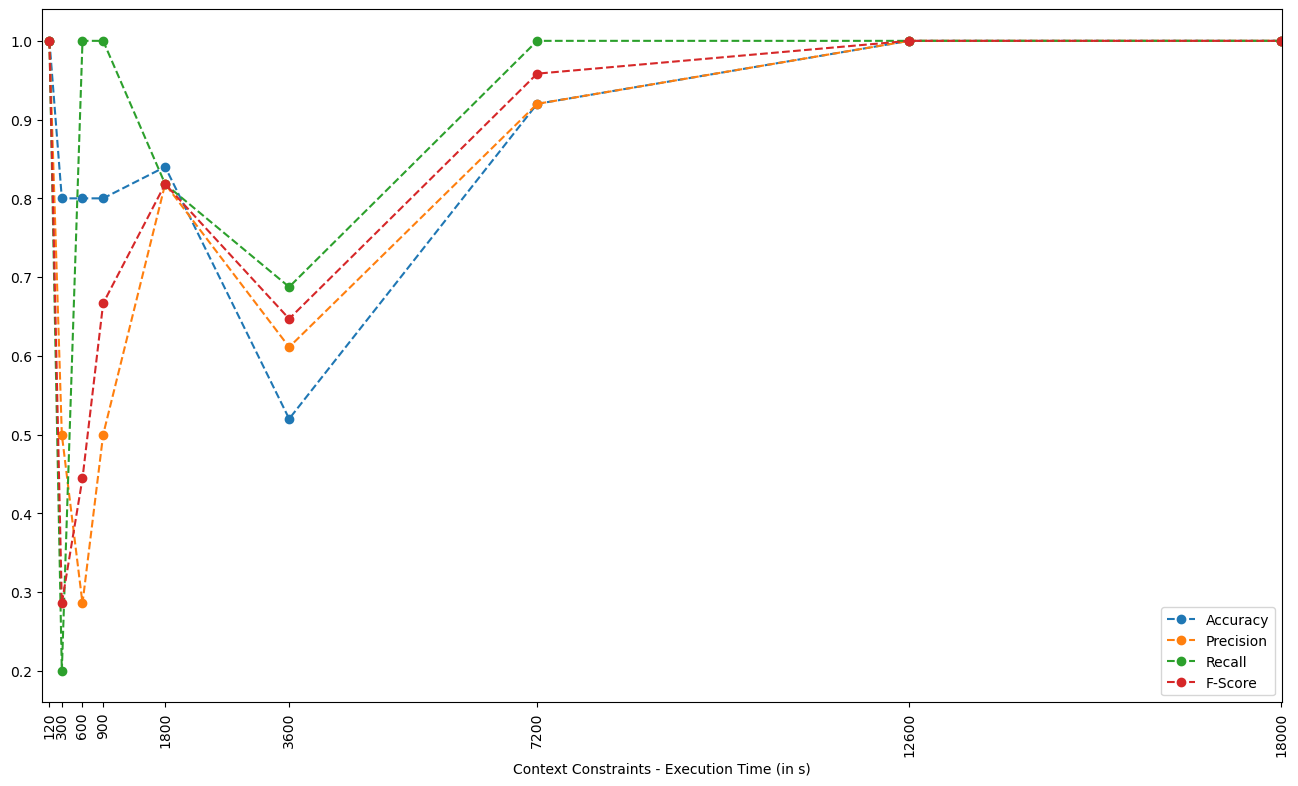

In [29]:
import matplotlib.pyplot as plt
print(list(Accuracy_approach.values()))
print(list(precision_approach.values()))
print(list(recall_approach.values()))
print(budgets)
plt.plot(budgets, list(Accuracy_approach.values()), label = "Accuracy", linestyle='--', marker='o')#alpha=0.2) 
plt.plot(budgets, list(precision_approach.values()), label = "Precision", linestyle='--', marker='o')
plt.plot(budgets, list(recall_approach.values()), label = "Recall", linestyle='--', marker='o') 
plt.plot(budgets, list(f_score.values()), label = "F-Score", linestyle='--', marker='o') 
plt.legend() 
plt.xlabel("Context Constraints - Execution Time (in s)")
plt.xticks(budgets, rotation=90)
plt.xlim(10,18010)
#plt.show()
plt.rcParams["figure.figsize"] = (16, 9)
plt.savefig('Approach_assessment.pdf')

In [38]:
import statistics
print("median accuracy:", statistics.median([1.0, 0.8, 0.8, 0.8, 0.84, 0.52, 0.92, 1.0, 1.0]))
print("median precision:", statistics.median(precision_approach.values()))
print("median recall:", statistics.median(recall_approach.values()))
print("median F-score:", statistics.median(f_score.values()))

median accuracy: 0.84
median precision: 0.8181818181818182
median recall: 1.0
median F-score: 0.8181818181818182
